In [1]:
import librosa
import librosa.display
from scipy import signal
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import math
from PyHa.statistics import *
from PyHa.IsoAutio import *
from PyHa.visualizations import *

ModuleNotFoundError: No module named 'PyHa'

## Testing 2D Correlation on Image 

In [2]:
rng = np.random.default_rng()
face = misc.face(gray=True) - misc.face(gray=True).mean()
template = np.copy(face[300:365,670:750])
template -= template.mean()
face = face + rng.standard_normal(face.shape) * 50
corr = signal.correlate2d(face,template,boundary='symm',mode='same')
y,x = np.unravel_index(np.argmax(corr),corr.shape)

C:\Users\harsh\anaconda3\envs\species-id\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


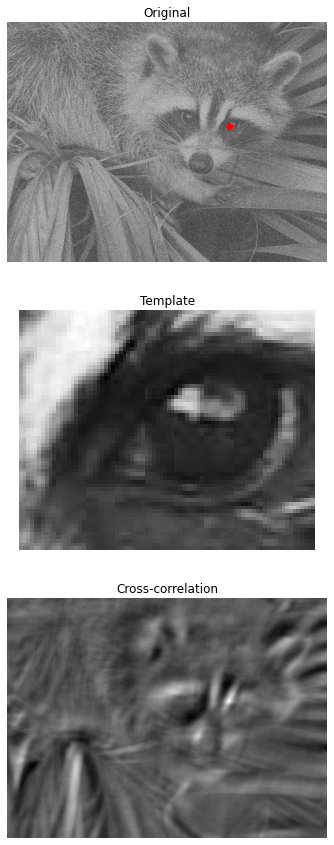

In [3]:
fig, (ax_orig, ax_template, ax_corr) = plt.subplots(3, 1,figsize=(6, 15))
# Plotting the original image
ax_orig.imshow(face,cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
# Plotting the template that was derived from the original image
ax_template.imshow(template,cmap='gray')
ax_template.set_title('Template')
ax_template.set_axis_off()
# Plotting the Cross-correlation output
ax_corr.imshow(corr,cmap='gray')
ax_corr.set_title('Cross-correlation')
ax_corr.set_axis_off()
ax_orig.plot(x,y,'ro')
fig.show()

In [4]:
# converting tuple to a 2d array since tuples are a bad data structure
print(corr.shape)

(768, 1024)


## Converting the 2D correlation output into 1D

In [5]:
corr_reduced_max = np.amax(corr,axis=0)

(1024,)


Text(0.5, 0, 'Pixel Width')

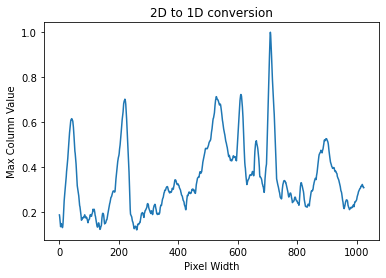

In [6]:
# With these preliminary results, it seems as if the max is the best option
# I think the medians and averages may work better in cases where there are 
# harmonics across an audio clip
plt.plot(corr_reduced_max/max(corr_reduced_max))
print(corr_reduced_max.shape)
plt.title("2D to 1D conversion")
plt.ylabel("Max Column Value")
plt.xlabel("Pixel Width")

In [7]:
corr_reduced_sum = corr.sum(axis=0)

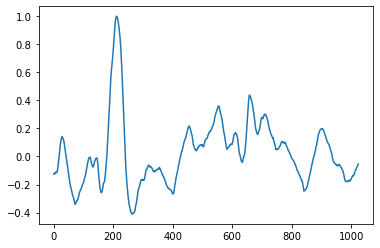

In [8]:
plt.plot(corr_reduced_sum/max(corr_reduced_sum))

In [9]:
corr_reduced_median = np.median(corr,axis=0)

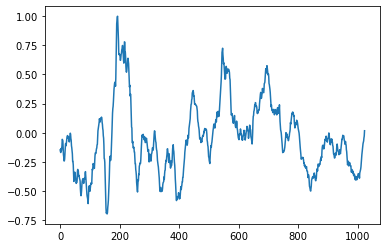

In [10]:
plt.plot(corr_reduced_median/max(corr_reduced_median))

## Testing 2D Correlation on Spectrograms

In [11]:
# Going to test with some Piha Calls, they usually peak a little bit above 5kHz, so I am going to bring the audio in
# at a 12kHz sample rate to reconstruct up to 6kHz
piha_clip_path = "./data/test/ScreamingPiha2.wav"
y,sr = librosa.load(piha_clip_path,sr=12000)
S = np.abs(librosa.stft(y))
print(S.shape)

(1025, 796)


Text(0, 0.5, 'Frequency (0-6kHz)')

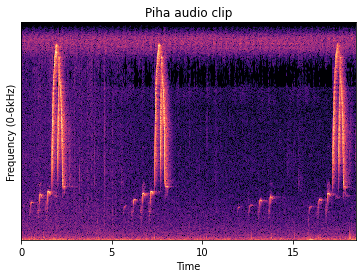

In [12]:
fig, ax = plt.subplots()
# Displaying a linear spectrogram. This y-limit is 6kHz.
# I really dislike the default settings found in Librosa for the x and y axis.
img = librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max), x_axis='time', ax=ax)
# It seems that 3s is a good time on this image.
plt.title("Piha audio clip")
plt.ylabel("Frequency (0-6kHz)")

In [13]:
# 12000 * 3 = 36000
print(y.shape)

(407197,)


In [14]:
template = np.abs(librosa.stft(y[36000:55000]))

In [15]:
print(template.shape)

(1025, 38)


Text(0.5, 1.0, 'Piha Template')

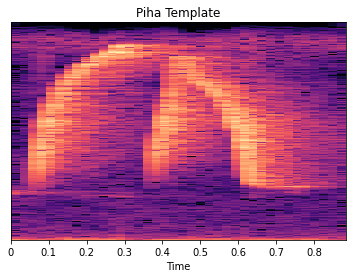

In [16]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(template,ref=np.max),x_axis='time',ax=ax)
plt.title("Piha Template")

In [17]:
# performing the sound cross-correlation
# This is very slow
corr = signal.correlate2d(S,template,boundary='symm',mode='same')

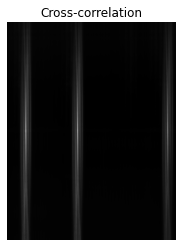

In [18]:
fig, ax_corr = plt.subplots()
ax_corr.imshow(corr,cmap='gray')
ax_corr.set_title('Cross-correlation')
ax_corr.set_axis_off()

(1025, 796)
(796,)


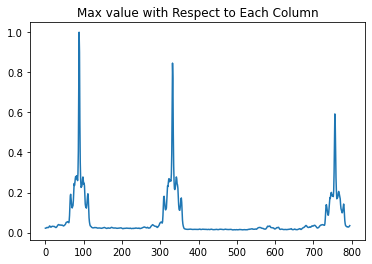

In [19]:
print(corr.shape)
# Maybe play around with SNR based peak detection, similar to that achieved on radio collar
# Try using Scipy built-in peak detection
corr_reduced_max = np.amax(corr,axis=0)
plt.plot(corr_reduced_max/max(corr_reduced_max))
plt.title("Max value with Respect to Each Column")
print(corr_reduced_max.shape)

Text(0.5, 1.0, 'Median Value with Respect to Each Column')

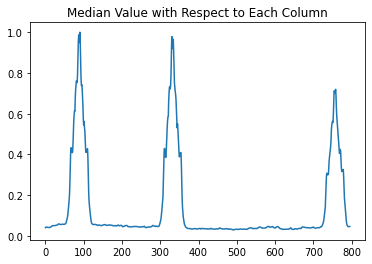

In [20]:
corr_reduced_median = np.median(corr,axis=0)
plt.plot(corr_reduced_median/max(corr_reduced_median))
plt.title("Median Value with Respect to Each Column")

Text(0.5, 1.0, 'Sum of Each Column')

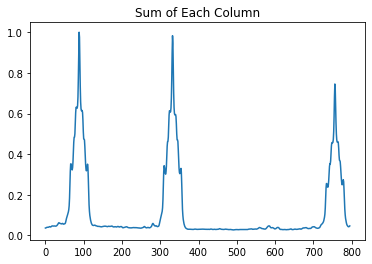

In [21]:
corr_reduced_sum = np.sum(corr,axis=0)
plt.plot(corr_reduced_sum/max(corr_reduced_sum))
plt.title("Sum of Each Column")

In [22]:
# finding a ratio between the number of samples in the original signal to the STFT (there is a better way to recognize this
# using signal processing fundamentals) This is a step that is taken inside of the steinberg isolate function
# Maybe try to build "Eigenfaces" but for bird calls
ratio = y.shape[0]/corr.shape[1]
print(ratio)

511.5540201005025


In [23]:
# Time to figure out how to connect this 1D local score array back into the Steinberg technique
# Setting up the Isolation Parameters
isolation_parameters = {
    "technique" : "steinberg",
    "threshold_type" : "median",
    "threshold_const" : 2.0,
    "threshold_min" : 0.0,
    "bi_directional_jump" : 0.05,
    "window_size" : 1.0 # Missing line, had to be added to fix
}
# "bi_directional_jump" : len(y[36000:55000])/sr 

In [24]:
test_df = steinberg_isolate(corr_reduced_max/max(corr_reduced_max),y,12000,"test_dir","test_file",isolation_parameters)

In [25]:
test_df

,FOLDER,IN FILE,CHANNEL,CLIP LENGTH,SAMPLE RATE,OFFSET,DURATION,MANUAL ID
0,test_dir,test_file,0,33.933083,12000,1.799500,3.597583,bird
1,test_dir,test_file,0,33.933083,12000,12.232417,3.512417,bird
2,test_dir,test_file,0,33.933083,12000,30.628417,3.171750,bird


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


No handles with labels found to put in legend.


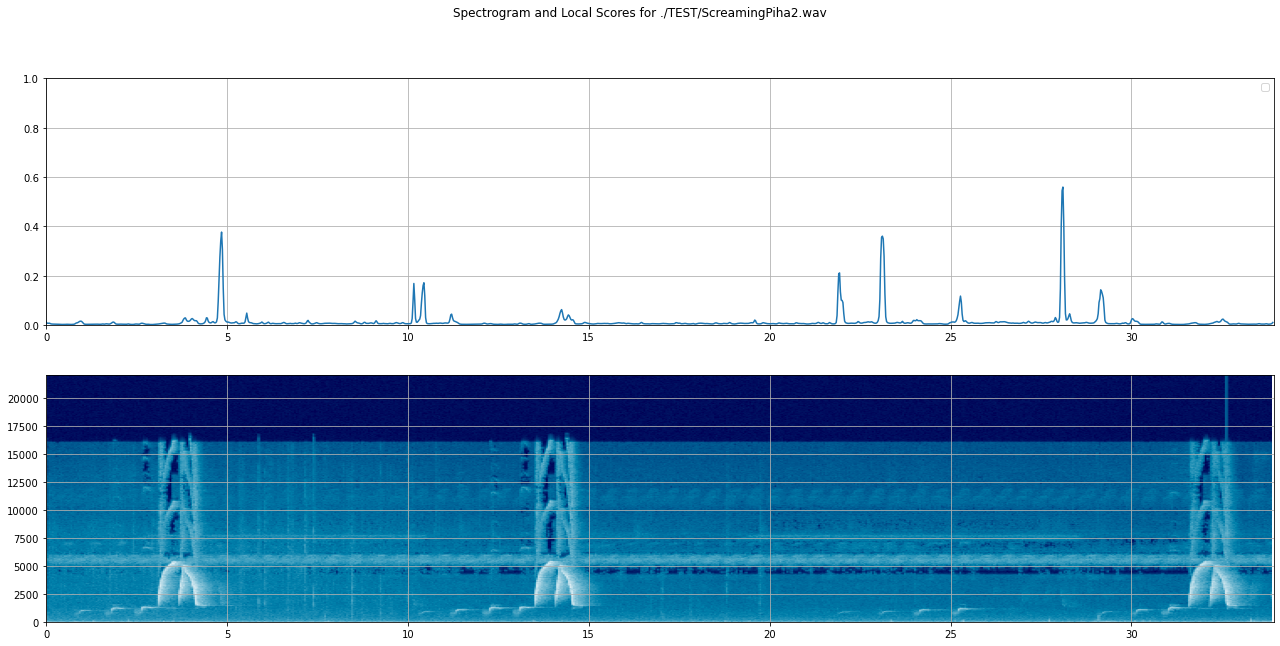

In [26]:
# The way Pyha is written right now, I need to pretend like these automated template matched annotations
# are human annotations. I wrote an issue to handle this later.
local_score_visualization("./data/test/ScreamingPiha2.wav")#, human_df = test_df) Had to pretend 2nd argument didn't exist

## Testing Out scipy.signal.fftconvolve() 

In [27]:
corr2 = signal.correlate2d(S,template[::-1,::-1])

In [28]:
# They don't have the exact same output, but lets see if we get similar end results
print(corr2.shape)

(2049, 833)


Text(0.5, 1.0, 'Max value with Respect to Each Column')

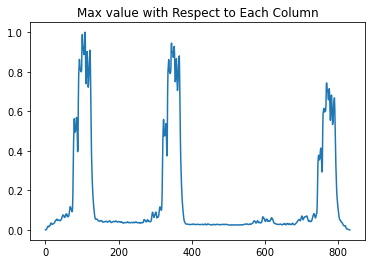

In [29]:
corr2_reduced_max = np.amax(corr2,axis=0)
plt.plot(corr2_reduced_max/max(corr2_reduced_max))
plt.title("Max value with Respect to Each Column")

In [30]:
test_df2 = steinberg_isolate(corr2_reduced_max/max(corr2_reduced_max),y,12000,"test_dir","test_file",isolation_parameters)

No handles with labels found to put in legend.


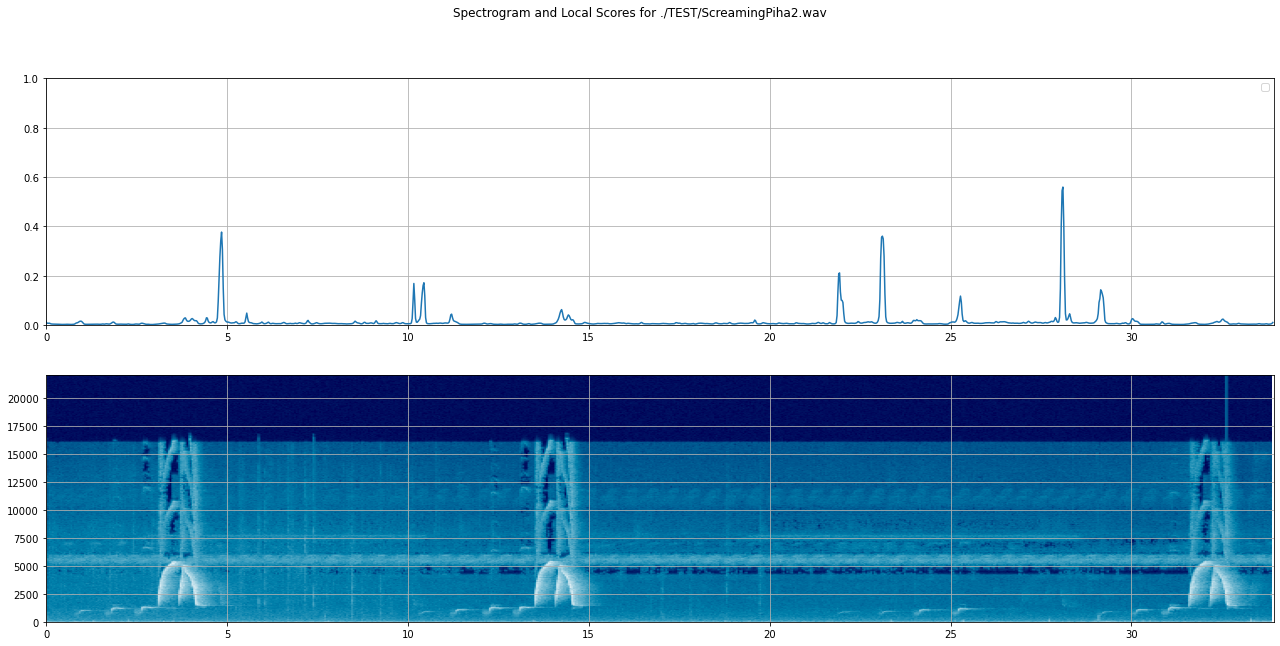

In [31]:
local_score_visualization("./data/test/ScreamingPiha2.wav")#, human_df = test_df2) Had to pretend 2nd argument didn't exist

## Experimenting with 1D correlation

In [32]:
corr3 = signal.correlate(y,y[36000:55000],mode="same")

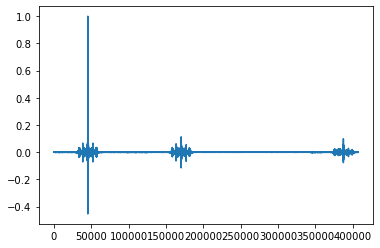

In [33]:
plt.plot(corr3/max(corr3))

In [34]:
# for some reason, the median threshold_type isn't working in this case 
# I switched around the isolation parameters to get it working
isolation_parameters = {
    "technique" : "steinberg",
    "threshold_type" : "pure",
    "threshold_const" : 0.02,
    "threshold_min" : 0.0,
    "bi_directional_jump" : 0.3,
    "window_size" : 1.0 # Missing line, had to be added to fix
}

In [35]:
test_df3 = steinberg_isolate(corr3/max(corr3),y,12000,"test_dir","test_file",isolation_parameters)

In [36]:
test_df3

,FOLDER,IN FILE,CHANNEL,CLIP LENGTH,SAMPLE RATE,OFFSET,DURATION,MANUAL ID
0,test_dir,test_file,0,33.933083,12000,2.275833,3.031667,bird
1,test_dir,test_file,0,33.933083,12000,12.683333,3.019833,bird
2,test_dir,test_file,0,33.933083,12000,30.812667,2.542250,bird


No handles with labels found to put in legend.


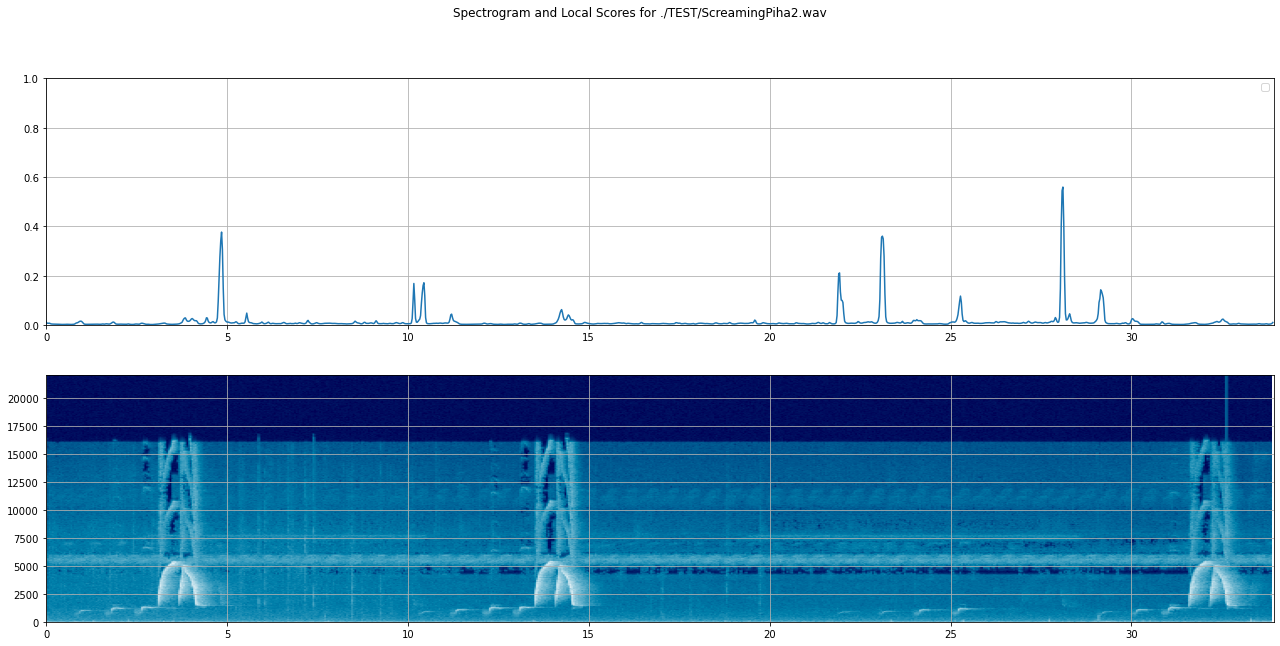

In [37]:
local_score_visualization("./data/test/ScreamingPiha2.wav")#,human_df = test_df3) Had to pretend 2nd argument didn't exist